# Installation

In [1]:
!pip install qiskit_optimization
!pip install docplex
!pip install qiskit
!pip install qiskit_aer
!pip install git+https://github.com/EnexaProject/enexa-tensor-reasoning.git@version1
!pip install pyqubo
!pip install tnreason

^C
  Cloning https://github.com/EnexaProject/enexa-tensor-reasoning.git (to revision version1) to c:\users\botond\appdata\local\temp\pip-req-build-si_1qmif
  Resolved https://github.com/EnexaProject/enexa-tensor-reasoning.git to commit a41455b254cfed47e3db3b7871d7046e2c188f4a
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/EnexaProject/enexa-tensor-reasoning.git 'C:\Users\Botond\AppData\Local\Temp\pip-req-build-si_1qmif'


# Background
Our goal is the exact conversion of a **HUBO** into a **QUBO** problem. To achieve this, we first convert a HUBO represented by a polynomial core into an **ILP** (Integer Linear Programming) problem. The idea is to represent higher order terms in the HUBO problem by purely linear terms. To do this, we introduce slack variables and enforce the same behavior as the higher-order terms through inequality constraints.

## Polynomial Core as Tensor

$\sum\limits_{i=0}^{m-1} \sigma_i (\prod\limits_{k\in A_i^+}x_k)(\prod\limits_{k\in A_i^-}(1-x_k))$ where $m$ is the number of clauses of a given CNF. $\sigma_i$ is the weight of a clause and $x_k$ is the $k$-th literal.

### Example

$p(x, y, z) = 2xz + x(1-y) + 3xyz - (1-x)(1-z) - yz$ where $x ,y, z \in \{0, 1\}$

The example is a HUBO of Order 3, $m$ would be 4 and $k \in \{0, 1, 2 \}$

## HUBO to ILP

To linearize the problem, the term $(\prod\limits_{k\in A_i^+}x_k)(\prod\limits_{k\in A_i^-}(1-x_k))$ can be summarized in a slack variable $z_i$. Equality is enforced by
1. $x_i ≥ z_i$
2. $(1-x_i) ≥ z_i$
3. $z_i\le \sum\limits_{k\in A_i^+}x_k - \sum\limits_{k\in A_i^-}x_k - |A_i^+| + 1$.

### Example

Let $z_0 = xyz$. To ensure that $z_0$ behaves just like $xyz$ we introduce the following constraints:

1. $z_0 ≤ x$
2. $z_0 ≤ y$
3. $z_0 ≤ z$
4. $z_0 ≥ x+y+z-2$

For $n$ literals we get $n+1$ constraints.


In [2]:
import docplex

In [3]:
from qiskit_optimization.translators import from_docplex_mp

from docplex.mp.model import Model
from tnreason import engine

def poly_to_cplex_model(polyCore):
    """
    Convert a HUBO into an ILP by introducing inequality constraints.
    All terms are replaced by slack variables and assosiated constraints.

    Args:
        polyCore (PolynomialCore)
    Returns:
        model: A docplex model.
    """

    model = Model("ILP_to_QUBO")

    variableDict = {
        color: model.binary_var(name=color) for color in polyCore.colors
    }

    slackVariableDict = {
        "slack" + str(j): model.binary_var(name="slack" + str(j)) for j in range(len(polyCore.values))
    }

    for j, entry in enumerate(polyCore.values):
        lowBound = 1
        for var in entry[1]:
            if entry[1][var] == 1:
                lowBound = lowBound + variableDict[var] - 1
                model.add_constraint(slackVariableDict["slack" + str(j)] <= variableDict[var])
            elif entry[1][var] == 0:
                lowBound = lowBound - variableDict[var]
                model.add_constraint(slackVariableDict["slack" + str(j)] <= (1 - variableDict[var]))
            else:
                raise ValueError("Index {} not supported, binary only!".format(entry[1][var]))
        model.add_constraint(lowBound <= slackVariableDict["slack" + str(j)])

    objective = 0
    for j, entry in enumerate(polyCore.values):
        objective = objective + entry[0] * slackVariableDict["slack" + str(j)]

    model.maximize(objective)
    return model

colors = ["a","b","c","d"]

polyCore = engine.get_core('PolynomialCore')(values=[(2, {"a":1, "b":1, "c":1}), (-1, {"a":1,"b":1,"d":1})], colors=colors, shape=[2 for key in colors])
#polyCore = engine.get_core("PolynomialCore")(values=[(2, {"a":1, "b":1}), (-1, {"a":1,"d":1}), (1, {"c":1,"d":1})], colors=colors, shape=[2 for key in colors])
#polyCore = engine.get_core("PolynomialCore")(values=[(1, {"a":1}), (1, {"b":1}), (1, {"d":1}), (1, {"c":1})], colors=colors, shape=[2 for key in colors])
#polyCore = engine.get_core("PolynomialCore")(values=[(1, {"a":1})], colors=["a"], shape=[2 for key in ["a"]])
#polyCore = engine.get_core("PolynomialCore")(values=[(1, {"a":1, "b":1})], colors=["a","b"], shape=[2 for key in ["a","b"]])
#polyCore = engine.get_core("PolynomialCore")(values=[(1, {"a":1})], colors=["a"], shape=[2 for key in ["a"]])
model = poly_to_cplex_model(polyCore)
model.prettyprint()


// This file has been generated by DOcplex
// model name is: ILP_to_QUBO
// single vars section
dvar bool a;
dvar bool b;
dvar bool c;
dvar bool d;
dvar bool slack0;
dvar bool slack1;

maximize
 2 slack0 - slack1;
 
subject to {
 slack0 <= a;
 slack0 <= b;
 slack0 <= c;
 a + b + c -2 <= slack0;
 slack1 <= a;
 slack1 <= b;
 slack1 <= d;
 a + b + d -2 <= slack1;

}


In [4]:
npCore = engine.convert(polyCore)
mlndistribution = npCore.exponentiate().normalize()
mlndistribution.values

array([[[[0.04259811, 0.04259811],
         [0.04259811, 0.04259811]],

        [[0.04259811, 0.04259811],
         [0.04259811, 0.04259811]]],


       [[[0.04259811, 0.04259811],
         [0.04259811, 0.04259811]],

        [[0.04259811, 0.01567097],
         [0.31475986, 0.11579368]]]])

In [5]:
max_coordinate = npCore.get_argmax()
print(max_coordinate)
print(npCore.values)

{'a': 1, 'b': 1, 'c': 1, 'd': 0}
[[[[ 0.  0.]
   [ 0.  0.]]

  [[ 0.  0.]
   [ 0.  0.]]]


 [[[ 0.  0.]
   [ 0.  0.]]

  [[ 0. -1.]
   [ 2.  1.]]]]


## ILP to QUBO

To convert the ILP problem into a QUBO, all inequality constraints must first be converted into equality constraints. This is achieved by introducing an additional slack variable for each inquality constraint.

### Case leq:

From inequality $a \le 1$ to equality $a + s_0 = 1$  

### Case geq:

From inequality $a \ge 1$ to equality $a - s_0 = 1$

Finally, the ILP with equality constraints is transformed into a QUBO by formulating a objective function. Those equality constraints, e.g. $\sum_i a_i x_i = b$ where $a_i$ and $b$ are numbers and $x_i$ is a variable, will be added to the objective function in the form of $M(b - \sum_i a_i x_i)^2$ where $M$ is a large number as penalty factor.

In [6]:
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp

qp=from_docplex_mp(model)
print(qp.prettyprint())
conv = QuadraticProgramToQubo()
qubo = conv.convert(qp)
print(qubo.prettyprint())

Problem name: ILP_to_QUBO

Maximize
  2*slack0 - slack1

Subject to
  Linear constraints (8)
    -a + slack0 <= 0  'c0'
    -b + slack0 <= 0  'c1'
    -c + slack0 <= 0  'c2'
    a + b + c - slack0 <= 2  'c3'
    -a + slack1 <= 0  'c4'
    -b + slack1 <= 0  'c5'
    -d + slack1 <= 0  'c6'
    a + b + d - slack1 <= 2  'c7'

  Binary variables (6)
    a b c d slack0 slack1

Problem name: ILP_to_QUBO

Minimize
  96*a^2 + 192*a*b + 96*a*c + 96*a*c3@int_slack@0 + 192*a*c3@int_slack@1
  + 96*a*c7@int_slack@0 + 192*a*c7@int_slack@1 + 96*a*d - 100*a*slack0
  - 100*a*slack1 + 96*b^2 + 96*b*c + 96*b*c3@int_slack@0 + 192*b*c3@int_slack@1
  + 96*b*c7@int_slack@0 + 192*b*c7@int_slack@1 + 96*b*d - 100*b*slack0
  - 100*b*slack1 + 48*c^2 + 96*c*c3@int_slack@0 + 192*c*c3@int_slack@1
  - 100*c*slack0 + 48*c3@int_slack@0^2 + 192*c3@int_slack@0*c3@int_slack@1
  + 192*c3@int_slack@1^2 + 48*c7@int_slack@0^2
  + 192*c7@int_slack@0*c7@int_slack@1 + 192*c7@int_slack@1^2
  + 96*d*c7@int_slack@0 + 192*d*c7@int_sl

In [14]:
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_aer.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA, SPSA, ADAM, NELDER_MEAD
from qiskit_optimization.algorithms import MinimumEigenOptimizer, OptimizationResultStatus, SolutionSample
import numpy as np
from typing import List, Tuple

def get_beta_gamma_sequential(n, beta, gamma):
    return [beta] * n + [gamma] * n

def get_beta_gamma_alternating(n, beta, gamma):
    return [beta, gamma] * n

def step(step:int,params:np.array,mean:float,error:float):
    print(f'step: {step}, mean: {mean}, params: {params}')

qaoa_p = len(qubo.variables) + 2

beta_gamma = get_beta_gamma_alternating(qaoa_p, 0, np.pi/2)

shots = 3000
sampler = Sampler(run_options={
        "shots": shots,
        "seed": 42,
        "max_parallel_threads": 0,
        "max_parallel_experiments": 0,
        "max_parallel_shots": 1,
        "statevector_parallel_threshold": 8,
        "device": "CPU"
    })
optimizer = COBYLA()
qaoa_mes = QAOA(sampler=sampler, optimizer=optimizer, reps=qaoa_p, callback=step,
               initial_point=beta_gamma)
exact_mes = NumPyMinimumEigensolver()
qaoa = MinimumEigenOptimizer(qaoa_mes)
exact = MinimumEigenOptimizer(exact_mes)
exact_result = exact.solve(qubo)
result = qaoa.solve(qubo)

print(result.prettyprint())

step: 1, mean: (-4.06466666666667+0j), params: [0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966]
step: 2, mean: (-4.06466666666667+0j), params: [1.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966]
step: 3, mean: (-16.886666666666684+0j), params: [0.0, 2.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0, 1.5707963267948966, 0.0,

In [15]:
qaoa_p

12

In [16]:
def discard_slacks(data, keep=1):
    samples = []

    for key, value in data.items():
        new_data = {}
        # Split the key by spaces and keep only the first 'keep' parts
        new_key = " ".join(key.split()[:keep])
        # Assign the value to the new key in the new dictionary
        new_data[new_key] = value
        samples.append(new_data)
    return samples

def get_samples(data):
    return {
    " ".join(f"{data.variables[i].name}={int(v)}" for i, v in enumerate(s.x)): s.probability
    for s in data.samples
    }

def sum_probabilities(dict_list):
    result = {}
    for d in dict_list:
        for key, value in d.items():
            # If the key is already in the result dictionary, add the value
            # Otherwise, initialize it with the current value
            if key in result:
                result[key] += value
            else:
                result[key] = value

    return result

def key_with_greatest_value(d):
    if not d:  # Check if the dictionary is empty
        return None
    return max(d, key=d.get)


#print(key_with_greatest_value(samples_for_plot))
#print(exact_result)
for s in result.samples:
    print(s)
samples_for_plot = get_samples(result)

samples = discard_slacks(samples_for_plot, keep=len(polyCore.colors))

summed_samples = sum_probabilities(samples)

SolutionSample(x=array([1., 1., 1., 0., 1., 0., 0., 0., 0., 0.]), fval=-2.0, probability=0.002, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1., 1., 0., 0., 1., 0., 1., 0.]), fval=0.0, probability=0.04133333333333333, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 1., 1., 0., 0., 0., 0., 0., 0.]), fval=0.0, probability=0.0003333333333333333, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 0., 1., 0., 0., 0., 1., 1., 0.]), fval=0.0, probability=0.005, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), fval=0.0, probability=0.0013333333333333333, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 0., 1., 0., 0., 1., 0., 0., 0.]), fval=0.0, probability=0.001, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1., 0., 0., 0., 1., 0., 0., 1.]), fval=0.0, probability=0.00566666666666666

Total variables:  10
P:  12
Shots:  3000


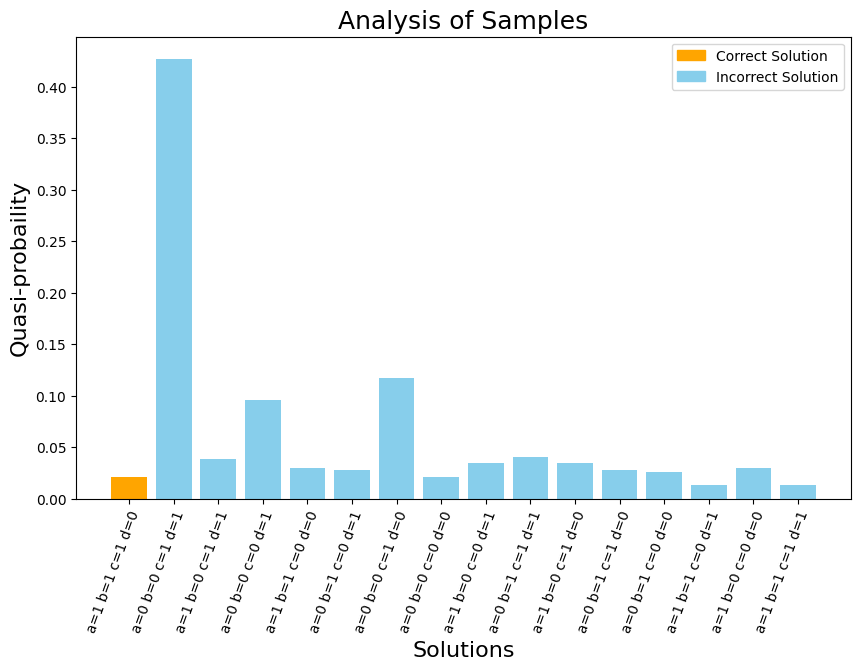

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def dict_to_string(input_dict):
    return ' '.join(f"{key}={value}" for key, value in input_dict.items())

labels = list(summed_samples.keys())
values = list(summed_samples.values())

# Define color scheme, with one bar having a different color
colors = ['skyblue' if label != dict_to_string(max_coordinate) else 'orange' for label in labels]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=colors)

# Labeling
plt.xlabel("Solutions", fontsize=16)
plt.ylabel("Quasi-probaility", fontsize=16)
plt.title("Analysis of Samples", fontsize=18)
plt.xticks(rotation=70, ha='right', rotation_mode='anchor')  # Rotate x-axis labels for readability

# Create custom legend
correct_patch = mpatches.Patch(color='orange', label='Correct Solution')
incorrect_patch = mpatches.Patch(color='skyblue', label='Incorrect Solution')
plt.legend(handles=[correct_patch, incorrect_patch])

print("Total variables: ", len(result.variables))
print("P: ",qaoa_p)
print("Shots: ",shots)
plt.show()

In [10]:
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

from qiskit.result import QuasiDistribution

def print_result(result):
    RED = "\033[91m"
    BLACK = "\033[90m"
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate,QuasiDistribution)
        else {k: np.abs(v) ** 2 for k,v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(),key=lambda x: x[1],reverse=True)

    for k,v in probabilities:
#        print(k,v)
        x = np.array([int(i) for i in list(reversed(k))])
        value = poopt.to_quadratic_program().objective.evaluate(x)
#        print("%10s\t%.4f\t\t%.4f" % (x, value, v))
        if np.all(x == result.x.astype(int)):
            print(RED + "%10s\t%8.4f\t%.4f" % (x, value, v))
        else:
            #print(x,result.x.astype(int))
            print(BLACK + "%10s\t%8.4f\t%.4f" % (x, value, v))

def rev_bstr(bstr):
    return ''.join(list(reversed(bstr)))

def binarize_label(qbits,label,reversed=True):
    formatter = "{0:0"+ str(qbits) + "b}"
    if reversed:
        return rev_bstr(formatter.format(label))
    else:
        return formatter.format(label)


def binarize_labels(qbits,labels,reversed=True):
    binarized = []
#    formatter = "{0:0"+ str(qbits) + "b}"
    for l in labels:
        binarized.append(binarize_label(qbits,l,reversed))
    return binarized

def feasibles(eigenstates,c,qbits):
    fs = {}
    nfs = {}
    for est in eigenstates:
        b = binarize_label(qbits,est)
        #if b.count('1') == c:
        fs[est] = eigenstates[est]
        #else:
            #nfs[est] = eigenstates[est]
    return fs,nfs


def plot_hist(eigenstates,eigenstates2,opt_x,opt_p,binlabels=False,qbits=None):
    items1 = sorted(eigenstates.items())
    #items2 = sorted(eigenstates2.items())

    if binlabels and (qbits is not None):
        x1 = binarize_labels(qbits,list(zip(*items1))[0])
        #x2 = binarize_labels(qbits,list(zip(*items2))[0])
    else:
        x1 = list(zip(*items1))[0]
        #x2 = list(zip(*items2))[0]
    y1 = list(zip(*items1))[1]
    #y2 = list(zip(*items2))[1]
    #print(items)
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.bar(x1,y1,label='feasible')
    #ax.bar(x2,y2,label='not feasible')
    ax.bar(opt_x,opt_p,label='optimal')

    ax.tick_params(axis='x',labelrotation=45)
    plt.legend()
    plt.show()

In [11]:
eigenstates = result.min_eigen_solver_result.eigenstate
print(eigenstates)
#fs,nfs = feasibles(eigenstates,0,qbits)
#opt_x = ''.join([ str(d) for d in result.x.astype(int)])
#opt_p = fs[int(''.join(list(reversed([ str(d) for d in result.x.astype(int)]))),2)]
#plot_hist(eigenstates,nfs,opt_x,opt_p,binlabels=True,qbits=qbits)

{382: 0.000333333333333, 72: 0.000333333333333, 1007: 0.000333333333333, 502: 0.000333333333333, 423: 0.000666666666667, 4: 0.000333333333333, 191: 0.000333333333333, 179: 0.001666666666667, 516: 0.000333333333333, 957: 0.001333333333333, 239: 0.001, 491: 0.001, 363: 0.002, 127: 0.001333333333333, 678: 0.001333333333333, 564: 0.001, 701: 0.001666666666667, 488: 0.001, 484: 0.003333333333333, 739: 0.001, 45: 0.002, 38: 0.002, 871: 0.001333333333333, 172: 0.001, 318: 0.000333333333333, 248: 0.001, 764: 0.001, 817: 0.001666666666667, 935: 0.000666666666667, 959: 0.001, 183: 0.001666666666667, 626: 0.001, 803: 0.000333333333333, 297: 0.001, 178: 0.002666666666667, 483: 0.001333333333333, 126: 0.001333333333333, 1016: 0.001666666666667, 743: 0.001, 182: 0.000333333333333, 319: 0.002, 942: 0.001, 950: 0.001333333333333, 501: 0.001666666666667, 1010: 0.001, 619: 0.002333333333333, 819: 0.001, 496: 0.002333333333333, 506: 0.001333333333333, 552: 0.002, 698: 0.002333333333333, 1022: 0.001, 685: